In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio

import fitting_functions

In [2]:
traces = ['090711e_0006', '090811c_0002', '090811d_0002', '090811d_0004','091111a_0001',
          '091111a_0003','091111c_0003','091211a_0002','091211a_0005']

In [3]:
data_folder = '../data/active/'

# Average power spectrum across all responses

As in the case of the anesthetized fish, we looked for a 30 Hz artifact. Because the eye position recordings are of varying durations, here we plot the average power for the pre-displacement saccade and the post-release eye position separately, truncating them at the length of the shortest response for each.

In [5]:
tranges_fix = [[],]*len(traces)
pes_fix = [[],]*len(traces)
tranges_release = [[],]*len(traces)
pes_release = [[],]*len(traces)

for i in range(len(traces)):
    full_trange, full_data, pe_start_index, displacement_index, release_index, step_pos = fitting_functions.importActiveData(data_folder+'raw/'+traces[i])
    tranges_fix[i] = full_trange[pe_start_index:displacement_index] - full_trange[pe_start_index]
    pes_fix[i] = full_data[pe_start_index:displacement_index]/full_data[pe_start_index]

    tranges_release[i] = np.concatenate((np.array([full_trange[release_index]]), full_trange[release_index+16:])) 
    pes_release[i] = np.concatenate((np.array([step_pos]), full_data[release_index+16:]))/step_pos

In [6]:
min_len_fix = np.min([len(tranges_fix[i]) for i in range(len(traces))])
min_len_release = np.min([len(tranges_release[i]) for i in range(len(traces))])

In [7]:
np.min([tranges_release[i][-1]-tranges_release[i][0] for i in range(len(traces))])

8.136

In [8]:
trange_fix_overall = tranges_fix[np.argmin([len(tranges_fix[i]) for i in range(len(traces))])]
trange_release_overall = tranges_release[np.argmin([len(tranges_release[i]) for i in range(len(traces))])]

In [9]:
pes_fix_ = np.vstack([pes_fix[i][:min_len_fix] for i in range(len(traces))])
pes_release_ = np.vstack([pes_release[i][:min_len_release] for i in range(len(traces))])

In [10]:
pes_fix_fft = np.fft.fft(pes_fix_, axis=1)
pes_fix_freq = np.fft.fftfreq(len(trange_fix_overall), trange_fix_overall[1])

pes_release_fft = np.fft.fft(pes_release_[:,1:], axis=1)
pes_release_freq = np.fft.fftfreq(len(trange_release_overall[1:]), trange_release_overall[2]-trange_release_overall[1])

In [11]:
pes_fix_power = np.abs(np.mean(pes_fix_fft, axis=0))**2
pes_release_power = np.abs(np.mean(pes_release_fft, axis=0))**2

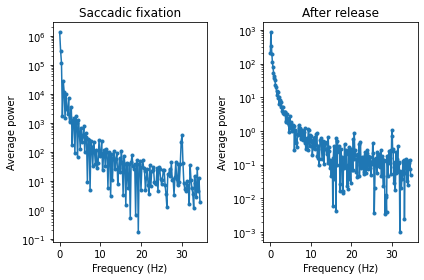

In [12]:
plt.subplot(1,2,1)
plt.yscale('log')
plt.plot(pes_fix_freq[:len(pes_fix_freq)//2], pes_fix_power[:len(pes_fix_freq)//2],'.-')
plt.title('Saccadic fixation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Average power')

plt.subplot(1,2,2)
plt.yscale('log')
plt.plot(pes_release_freq[:len(pes_release_freq)//2], pes_release_power[:len(pes_release_freq)//2],'.-')
plt.title('After release')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Average power')

plt.tight_layout()

# Plot all responses individually

The averaged response does not show a strong peak in the post-displacement eye position, so we looked at the full time lengths for each response individually to look for the existence of the artifact peak.

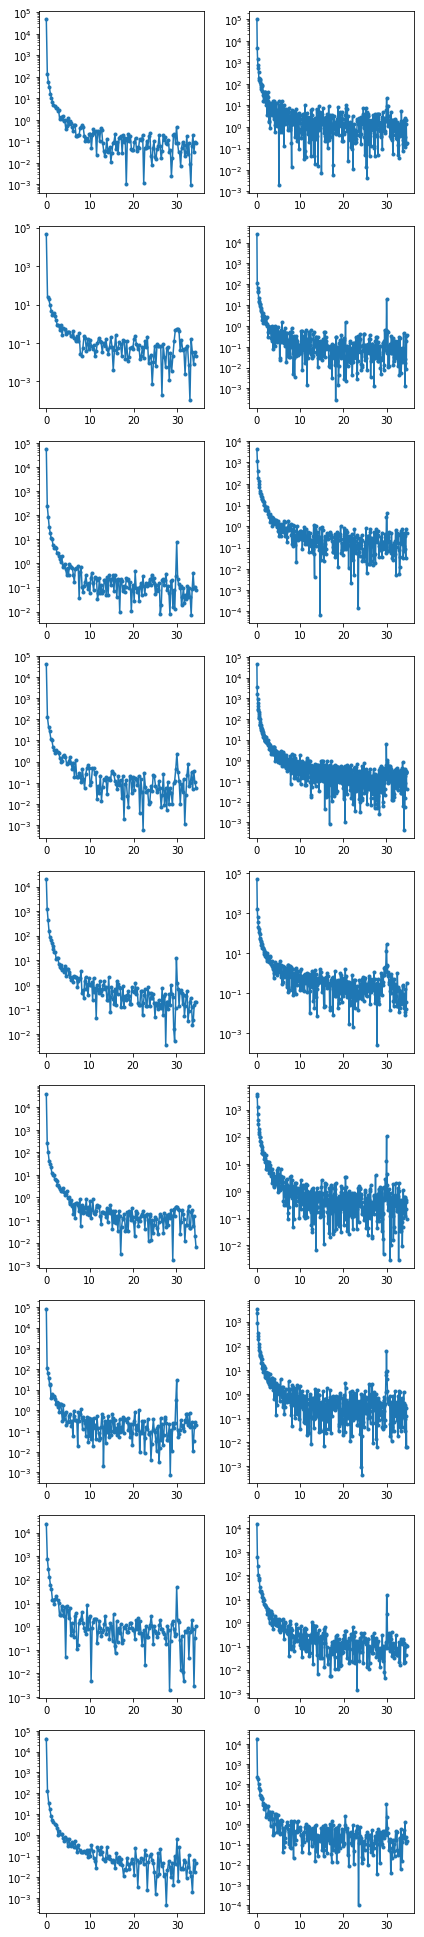

In [97]:
plt.figure(figsize=((6, 27)))
for i in range(len(traces)):
    fft_fix = np.fft.fft(pes_fix[i])
    fft_release = np.fft.fft(pes_release[i][1:])
    
    fft_freq_fix = np.fft.fftfreq(len(tranges_fix[i]), tranges_fix[i][1])
    fft_freq_release = np.fft.fftfreq(len(tranges_release[i][1:]), tranges_release[i][2]-tranges_release[i][1])
    
    plt.subplot(9,2,2*i+1)
    plt.yscale('log')
    plt.plot(fft_freq_fix[:len(fft_freq_fix)//2], np.abs(fft_fix[:len(fft_freq_fix)//2])**2,'.-')
    
    plt.subplot(9,2,2*i+2)
    plt.yscale('log')
    plt.plot(fft_freq_release[:len(fft_freq_release)//2], np.abs(fft_release[:len(fft_freq_release)//2])**2,'.-')
plt.tight_layout()

# Fix individual responses 

Because of the frequency binning of each response, the widths of the artifact peaks differ across responses. Here, we removed the peaks by manually looking at the width of the peak for each individual response.

In [196]:
i = 8

full_trange, full_data, pe_start_index, displacement_index, release_index, step_pos = fitting_functions.importActiveData(data_folder + 'raw/'+traces[i]+'.mat')

trange_fix = full_trange[pe_start_index:displacement_index] - full_trange[pe_start_index]
pe_fix = full_data[pe_start_index:displacement_index]/full_data[pe_start_index]

trange_release = np.concatenate((np.array([full_trange[release_index]]), full_trange[release_index+16:])) 
pe_release = np.concatenate((np.array([step_pos]), full_data[release_index+16:]))/step_pos

fft_fix = np.fft.fft(pe_fix)
fft_fix_new = np.copy(fft_fix)

fft_release = np.fft.fft(pe_release[1:])
fft_release_new = np.copy(fft_release)

fft_freq_fix = np.fft.fftfreq(len(trange_fix), trange_fix[1])
fft_freq_release = np.fft.fftfreq(len(trange_release[1:]), trange_release[2]-trange_release[1])

fix_max = len(fft_fix)//2-50 + np.argmax(np.abs(fft_fix[len(fft_fix)//2-50:len(fft_fix)//2])**2)
release_max = len(fft_release)//2-100+np.argmax(np.abs(fft_release[len(fft_release)//2-100:len(fft_release)//2])**2)

mean_window_size = 5

fix_window_size = 1
release_window_size = 1

fft_fix_new[fix_max-fix_window_size:fix_max+fix_window_size+1] *= np.mean(np.abs(np.concatenate((fft_fix[fix_max-fix_window_size-mean_window_size:fix_max-fix_window_size], 
                                                                                       fft_fix[fix_max+fix_window_size+1:fix_max+fix_window_size+mean_window_size+1]))))/np.abs(fft_fix[fix_max-fix_window_size:fix_max+fix_window_size+1])

fft_fix_new[-fix_max-fix_window_size:-fix_max+fix_window_size+1] *= np.mean(np.abs(np.concatenate((fft_fix[-fix_max-fix_window_size-mean_window_size:-fix_max-fix_window_size+1], 
                                                                                       fft_fix[-fix_max+fix_window_size:-fix_max+fix_window_size+mean_window_size+1]))))/np.abs(fft_fix[-fix_max-fix_window_size:-fix_max+fix_window_size+1])

fft_release_new[release_max-release_window_size:release_max+release_window_size+1] *= np.mean(np.abs(np.concatenate((fft_release[release_max-release_window_size-mean_window_size:release_max-release_window_size], 
                                                                                       fft_release[release_max+release_window_size+1:release_max+release_window_size+mean_window_size+1]))))/np.abs(fft_release[release_max-release_window_size:release_max+release_window_size+1])

fft_release_new[-release_max-release_window_size:-release_max+release_window_size+1] *= np.mean(np.abs(np.concatenate((fft_release[-release_max-release_window_size-mean_window_size:-release_max-release_window_size+1], 
                                                                                       fft_release[-release_max+release_window_size:-release_max+release_window_size+mean_window_size+1]))))/np.abs(fft_release[-release_max-release_window_size:-release_max+release_window_size+1])



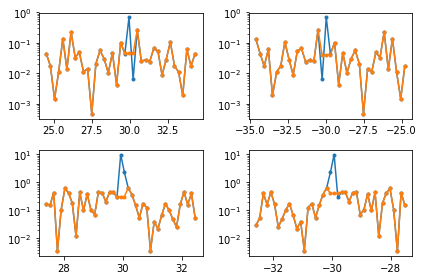

In [197]:
plot_window_size = 20

plt.subplot(2,2,1)
plt.yscale('log')
plt.plot(fft_freq_fix[fix_max-plot_window_size:np.minimum(fix_max+plot_window_size+1, len(fft_freq_fix)//2)],
         np.abs(fft_fix[fix_max-plot_window_size:np.minimum(fix_max+plot_window_size+1, len(fft_freq_fix)//2)])**2, '.-')
plt.plot(fft_freq_fix[fix_max-plot_window_size:np.minimum(fix_max+plot_window_size+1, len(fft_freq_fix)//2)],
         np.abs(fft_fix_new[fix_max-plot_window_size:np.minimum(fix_max+plot_window_size+1, len(fft_freq_fix)//2)])**2, '.-')


plt.subplot(2,2,2)
plt.yscale('log')
plt.plot(fft_freq_fix[np.maximum(-len(fft_freq_fix)//2+1, -(fix_max+plot_window_size+1)):-(fix_max-plot_window_size)],
         np.abs(fft_fix[np.maximum(-len(fft_freq_fix)//2+1, -(fix_max+plot_window_size+1)):-(fix_max-plot_window_size)])**2, '.-')
plt.plot(fft_freq_fix[np.maximum(-len(fft_freq_fix)//2+1, -(fix_max+plot_window_size+1)):-(fix_max-plot_window_size)],
         np.abs(fft_fix_new[np.maximum(-len(fft_freq_fix)//2+1, -(fix_max+plot_window_size+1)):-(fix_max-plot_window_size)])**2, '.-')



plt.subplot(2,2,3)
plt.yscale('log')
plt.plot(fft_freq_release[release_max-plot_window_size:np.minimum(release_max+plot_window_size+1, len(fft_freq_release)//2)],
         np.abs(fft_release[release_max-plot_window_size:np.minimum(release_max+plot_window_size+1, len(fft_freq_release)//2)])**2, '.-')
plt.plot(fft_freq_release[release_max-plot_window_size:np.minimum(release_max+plot_window_size+1, len(fft_freq_release)//2)],
         np.abs(fft_release_new[release_max-plot_window_size:np.minimum(release_max+plot_window_size+1, len(fft_freq_release)//2)])**2, '.-')


plt.subplot(2,2,4)
plt.yscale('log')
plt.plot(fft_freq_release[np.maximum(-len(fft_freq_release)//2+1, -(release_max+plot_window_size+1)):-(release_max-plot_window_size)],
         np.abs(fft_release[np.maximum(-len(fft_freq_release)//2+1, -(release_max+plot_window_size+1)):-(release_max-plot_window_size)])**2, '.-')
plt.plot(fft_freq_release[np.maximum(-len(fft_freq_release)//2+1, -(release_max+plot_window_size+1)):-(release_max-plot_window_size)],
         np.abs(fft_release_new[np.maximum(-len(fft_freq_release)//2+1, -(release_max+plot_window_size+1)):-(release_max-plot_window_size)])**2, '.-')

plt.tight_layout()


In [192]:
pe_fix_fixed = np.real(np.fft.ifft(fft_fix_new))
pe_release_fixed = np.concatenate((np.array([1]), np.real(np.fft.ifft(fft_release_new))))

full_data_new = np.concatenate((pe_fix_fixed*full_data[pe_start_index], step_pos*np.ones(release_index - displacement_index), pe_release_fixed*step_pos))
full_trange_new = np.concatenate((full_trange[pe_start_index:release_index+1], full_trange[release_index+16:]))-full_trange[pe_start_index]

sio.savemat(data_folder + 'fixed/'+traces[i]+'.mat',\
            {'trange':full_trange_new, 'data':full_data_new, 
             'displacement_index':displacement_index - pe_start_index, 'release_index': release_index-pe_start_index }, appendmat=False) 